# Closure bars

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine
from math import ceil

import matplotlib.pyplot as plt
import matplotlib.colors as cl
from matplotlib.ticker import FormatStrFormatter

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob

import m2lib22.box as box
import m2lib22.aviso as aviso
import m2lib22.cstes as cstes
import m2lib22.diagnosis as diag
import m2lib22.erastar as eras
import m2lib22.stress_to_windterm as stw

from m2lib22.cstes import labels, zarr_dir

plt.rcParams.update({'font.size':15})

In [2]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    #cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    w = cluster.scale(jobs=3)
else:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.146:8787/status,
Dashboard: http://10.148.0.146:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.146:50537,Workers: 0
Dashboard: http://10.148.0.146:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## IMPORT DATA, build dataset

In [3]:
ds_all = xr.open_zarr(zarr_dir+'/'+'stat_acc_bin_all.zarr').persist()
ds_sentinel = xr.open_zarr(zarr_dir+'/'+'stat_acc_bin_sentinel.zarr').persist()
ds_saral = xr.open_zarr(zarr_dir+'/'+'stat_acc_bin_saral.zarr').persist()
ds_argos = xr.open_zarr(zarr_dir+'/'+'stat_acc_bin_argos.zarr').persist()
ds_gps = xr.open_zarr(zarr_dir+'/'+'stat_acc_bin_gps.zarr').persist()
ds_sentinel_gps = xr.open_zarr(zarr_dir+'/'+'stat_acc_bin_sentinel_gps.zarr').persist()
ds_saral_gps = xr.open_zarr(zarr_dir+'/'+'stat_acc_bin_saral_gps.zarr').persist()

## Ploting functions

In [8]:
def plot_closure_bar(ds, id_, ax, title=1):
    """ Plot closure bars for a combination on the axis ax.
    
    Parameters
    ----------
    ds : dataset with rms of x, excx and sum (created by )
    id_: identification of the combination
    ax : axis on which to plot

    """
    dic = ds['rms_sum_'+id_].attrs
    acc = 'rms_'+dic['acc']
    cor = 'rms_'+dic['coriolis']
    ggrad = 'rms_'+dic['ggrad']
    wd = 'rms_'+dic['wind']

    # ACC X
    ax.bar(1.5, (ds[acc] + ds['rms_exc_acc_' + id_])**2,
           color ='lightgrey', width = 0.45, zorder=3, align = 'center',)
    ax.bar(1.5, (ds[acc] - ds['rms_exc_acc_' + id_])**2,
           color ='w', width = 0.45, zorder=3, align = 'center',)
    ax.bar(1.5, ds['rms_exc_acc_' + id_]**2,
           color = 'lightsteelblue', width = 0.4, zorder=3, align = 'center')
    ax.bar(1.5, ds[acc]**2, bottom = ds['rms_exc_acc_' + id_]**2,
           color = 'red', width = 0.4, zorder=3, align = 'center')

    # CORIOLIS
    ax.bar(2, (ds['rms_exc_coriolis_' + id_] + ds[cor])**2,
           color='lightgrey', width = 0.45, zorder=3, align = 'center',)
    ax.bar(2, (ds['rms_exc_coriolis_' + id_] - ds[cor])**2,
           color='w', width = 0.45, zorder=3, align = 'center', )
    ax.bar(2, ds['rms_exc_coriolis_' + id_]**2,
           color = 'lightsteelblue', width = 0.4, zorder=3, align = 'center')
    ax.bar(2, ds[cor]**2, bottom = ds['rms_exc_coriolis_' + id_]**2,
           color = 'green', width = 0.4, zorder=3, align = 'center')

    # G GRADIENT SLA
    ax.bar(2.5, (ds['rms_exc_ggrad_' + id_] + ds[ggrad])**2,
           color ='lightgrey', width = 0.45, zorder=3, align = 'center',)
    ax.bar(2.5, (ds['rms_exc_ggrad_' + id_] - ds[ggrad])**2,
           color ='w', width = 0.45, zorder=3, align = 'center',)
    ax.bar(2.5, ds['rms_exc_ggrad_' + id_]**2,
           color = 'lightsteelblue', width = 0.4, zorder=3, align = 'center')
    ax.bar(2.5, ds[ggrad]**2, bottom = ds['rms_exc_ggrad_' + id_]**2,
           color = 'c', width = 0.4, zorder=3, align = 'center')

    # WIND
    ax.bar(3, (ds['rms_exc_wind_' + id_] + ds[wd])**2,
           color ='lightgrey', width = 0.45, zorder=3, align = 'center',)
    ax.bar(3, (ds['rms_exc_wind_' + id_] - ds[wd])**2,
           color ='w', width = 0.45, zorder=3, align = 'center',)
    ax.bar(3, ds['rms_exc_wind_' + id_]**2,
           color = 'lightsteelblue', width = 0.4, zorder=3, align = 'center')
    ax.bar(3, ds[wd]**2, bottom = ds['rms_exc_wind_' + id_]**2,
           color = 'mediumvioletred', width = 0.4, zorder=3, align = 'center')
    
    #SUM of rms^2
    ax.bar(1,ds[acc]**2,
           color = 'red', width = 0.4, zorder=3, align = 'center')
    ax.bar(1, ds[cor]**2, bottom = ds[acc]**2,
           color = 'green', width = 0.4, zorder=3, align = 'center')
    ax.bar(1, ds[ggrad]**2, bottom = ds[acc]**2+ds[cor]**2,
           color = 'c', width = 0.4, zorder=3, align = 'center')
    ax.bar(1, ds[wd]**2, bottom = ds[acc]**2+ds[cor]**2+ds[ggrad]**2,
           color = 'mediumvioletred', width = 0.4, zorder=3, align = 'center')
    Ss=ds[acc]**2+ds[cor]**2+ds[ggrad]**2+ds[wd]**2
    ax.text(0.75, Ss+Ss/30, str(np.format_float_scientific(Ss.values,precision = 3)))

    ax.set_ylabel(r'Mean square $\langle ...^2 \rangle$ [$m^2/s^4$]')
    if isinstance(title, int): ax.set_title(id_)
    else : ax.set_title(title+'\n'+id_+'\n')
    
    #TOTAL
    S = ds['rms_sum_'+id_]**2
    ax.bar(0.5, S, color ='k',width = 0.4, zorder=3)
    ax.text(0.25, S+S/20, str(np.format_float_scientific(S.values,precision = 3)))
    ax.axhline(y=S, c="k", linewidth=2, ls=':', zorder=4)
    
    #ax.set_ylim((0,8e-5))
    ax.grid(axis='y', zorder=0)
    
    N=np.arange(0.5,3.5, 0.5) 
    g = ds[ggrad].attrs['long_name'].replace('rms[',r'').replace(']','').replace('altimatchup','aviso').replace('driftermatchup','aviso').split('+')
    ggrad_tick='$\n $+'.join(g)
    #w = ds_all['rms_es_cstrio_z15_alti_wd_x'].attrs['long_name'].replace('rms[',r'').replace(']','').split(' from')
    #wd_tick = '\n from'.join(w)
    ticks = (r'$\langle S^2\rangle$',r'$\sum_x \langle x^2\rangle$',r'$d_tu$', r'$-fv$', ggrad_tick, r'$\frac{1}{\rho}\partial_z\tau_x$')
    ax.set_xticks(N, ticks,)

    print(f'acc:{ds[acc].values**2}, coriolis:{ds[cor].values**2}, ggrad:{ds[ggrad].values**2}, wind:{ds[wd].values**2}')

In [5]:
def plot_comp_closure_bar(ds, ID, fig_title=1, titles=1, ncols=2, figsize='default', bottom = 0.15, loc='lower center'):
    """ Plot closure bars for a list of combinations.
    
    Parameters
    ----------
    ds : dataset with rms of x, excx and sum (created by )
    ID: list of identifiction to pass to plot_closure_bars
    fig_title : str, subtitle of the figure
    titles : list of str, of titles of each ax plot
    ncols : int, number of legend columns 
    figsize : tuple, figsize
    bottom : float, bottom limit of tight layout rect
    loc : str, legend localization
    """
    if titles==1 : titles=np.ones_like(ID)
    
    nrows = ceil(len(ID)/ncols)
    
    if figsize=='default':
        # Define the figure and each axis for the 3 rows and 3 columns
        fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                            sharey='all',
                            figsize=(ncols*6,nrows*7))
    else:        
        # Define the figure and each axis for the 3 rows and 3 columns
        fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                            sharey='all',
                            figsize=figsize)

    # axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
    axs=axs.flatten()
    

    #Loop over all of the variables
    for i in range(len(ID)):
        plot_closure_bar(ds, ID[i],axs[i], title=titles[i])
    if isinstance(fig_title, str):
        fig.suptitle(fig_title)
         
    # Delete the unwanted axes
    for i in np.arange(len(ID),nrows*2):
        fig.delaxes(axs[i])
        
    colors=['k', 'lightsteelblue','lightgrey', 'red', 'green', 'c','mediumvioletred']
    labels_ = [r'$\langle S^2\rangle$',
           r'$\langle S_{-x}^2\rangle$',
           r'$[(\sqrt{\langle S_{-x}^2\rangle}-\sqrt{\langle x^2\rangle})^2,(\sqrt{\langle S_{-x}^2\rangle}+\sqrt{\langle x^2\rangle})^2$]',
           r'$\langle (x=d_tu)^2\rangle $ from drifters',
          r'$\langle (x=-fv)^2\rangle$ from drifters',
          r"$\langle (x=g\partial_x\eta)^2\rangle$",
           r"$\langle (x=\frac{1}{\rho}\partial_z\tau_x)^2\rangle$",
          ]                                                                                                                                                           
             
    handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels_))]
    fig.legend(handles, labels_, ncol=3, loc=loc)#, bbox_to_anchor=(1,0.5))#bbox_transform=fig.transFigure,
    fig.tight_layout(rect=[0,bottom,1,1])#left, bottom, right, top (default is 0,0,1,1)

In [6]:
def plot_S_bars(ds_list, ID, ticks, fig_title=1):
    """ Plot closure bars for a list of combinations.
    
    Parameters
    ----------
    ds_list : dataset list  with rms of x, excx and sum (created by )
    ID: list of identifiction 
    ticks : list of str, ticks
    fig_title : str, of titles of each ax plot

    """
    nv=len(ds_list)
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(nv*1.7,5))
    N=np.arange(1,nv+1)
    ax.set_xticks(N, ticks,)
    S_list = [ds_list[i]['rms_sum_'+ID[i]]**2 for i in N-1]
    ax.bar(N,S_list, color = 'k',width = 0.9)
    #
    for i in N:
        ax.text(i-0.5, S_list[i-1]+0.1e-10, str(np.format_float_scientific(S_list[i-1].values,precision = 3)))

   
    ax.grid(axis='y', zorder=0)
    ax.set_ylabel(r'$\langle S^2 \rangle$ [$m^2/s^4$]')
    ax.set_ylim(0,7.5e-10)
    if isinstance(fig_title, str):
        fig.suptitle(fig_title,)
    else : fig.suptitle(r'$\langle S^2 \rangle$',)
    fig.tight_layout(rect=[0,0,1,1.05])#left, bottom, right, top (default is 0,0,1,1)

In [9]:
id_comb = ['co_es_cstrio_z0_alti_x', 
'co_es_cstrio_z0_drifter_x',
'co_e5_cstrio_z0_alti_x', 
'co_e5_cstrio_z0_drifter_x',
'co_es_cstrio_z15_alti_x', 
'co_es_cstrio_z15_drifter_x',
'co_e5_cstrio_z15_alti_x',
'co_e5_cstrio_z15_drifter_x',
'co_denoised_es_cstrio_z0_alti_x',
'co_denoised_es_cstrio_z0_drifter_x',
'co_denoised_e5_cstrio_z0_alti_x',
'co_denoised_e5_cstrio_z0_drifter_x',
'co_denoised_es_cstrio_z15_alti_x',
'co_denoised_es_cstrio_z15_drifter_x',
'co_denoised_e5_cstrio_z15_alti_x',
'co_denoised_e5_cstrio_z15_drifter_x',
'aviso_es_cstrio_z0_alti_x',
'aviso_e5_cstrio_z0_alti_x',
'aviso_es_cstrio_z15_alti_x',
'aviso_e5_cstrio_z15_alti_x',
'aviso_es_cstrio_z0_drifter_x',
'aviso_e5_cstrio_z0_drifter_x',
'aviso_es_cstrio_z15_drifter_x',
'aviso_e5_cstrio_z15_drifter_x',
'aviso_adt_es_cstrio_z0_alti_x',
'aviso_adt_e5_cstrio_z0_alti_x',
'aviso_adt_es_cstrio_z15_alti_x',
'aviso_adt_e5_cstrio_z15_alti_x',
'aviso_adt_es_cstrio_z0_drifter_x',
'aviso_adt_e5_cstrio_z0_drifter_x',
'aviso_adt_es_cstrio_z15_drifter_x',
'aviso_adt_e5_cstrio_z15_drifter_x',
'co_adt_es_cstrio_z0_alti_x',
'co_adt_es_cstrio_z0_drifter_x',
'co_adt_e5_cstrio_z0_alti_x',
'co_adt_e5_cstrio_z0_drifter_x',
'co_adt_es_cstrio_z15_alti_x',
'co_adt_es_cstrio_z15_drifter_x',
'co_adt_e5_cstrio_z15_alti_x',
'co_adt_e5_cstrio_z15_drifter_x',
'co_adt_oceantide_es_cstrio_z0_alti_x',
'co_adt_oceantide_es_cstrio_z0_drifter_x',
'co_adt_oceantide_e5_cstrio_z0_alti_x',
'co_adt_oceantide_e5_cstrio_z0_drifter_x',
'co_adt_oceantide_es_cstrio_z15_alti_x',
'co_adt_oceantide_es_cstrio_z15_drifter_x',
'co_adt_oceantide_e5_cstrio_z15_alti_x',
'co_adt_oceantide_e5_cstrio_z15_drifter_x',
'co_adt_oceantide_dac_es_cstrio_z0_alti_x',
'co_adt_oceantide_dac_es_cstrio_z0_drifter_x',
'co_adt_oceantide_dac_e5_cstrio_z0_alti_x',
'co_adt_oceantide_dac_e5_cstrio_z0_drifter_x',
'co_adt_oceantide_dac_es_cstrio_z15_alti_x',
'co_adt_oceantide_dac_es_cstrio_z15_drifter_x',
'co_adt_oceantide_dac_e5_cstrio_z15_alti_x',
'co_adt_oceantide_dac_e5_cstrio_z15_drifter_x',
'aviso_es_cstrio_z0_alti_y',
'aviso_e5_cstrio_z0_alti_y',
'aviso_es_cstrio_z15_alti_y',
'aviso_e5_cstrio_z15_alti_y',
'aviso_es_cstrio_z0_drifter_y',
'aviso_e5_cstrio_z0_drifter_y',
'aviso_es_cstrio_z15_drifter_y',
'aviso_e5_cstrio_z15_drifter_y',
'aviso_es_cstrio_z0_alti_y',
'aviso_e5_cstrio_z0_alti_y',
'aviso_es_cstrio_z15_alti_y',
'aviso_e5_cstrio_z15_alti_y',
'aviso_es_cstrio_z0_drifter_y',
'aviso_e5_cstrio_z0_drifter_y',
'aviso_es_cstrio_z15_drifter_y',
'aviso_e5_cstrio_z15_drifter_y']

# all vs gps only vs argos only

id_='co_adt_oceantide_es_cstrio_z15_alti_x'
#fig_title='All drifterd vs gps vs argos'
fig_title=1
fig, axs = plt.subplots(nrows=1,ncols=3,
                            sharey='all',
                            figsize=(14,5))
plot_closure_bar(ds_all, id_,axs[0], title = 'all' )
plot_closure_bar(ds_gps, id_,axs[1], title = 'gps' )
plot_closure_bar(ds_argos, id_,axs[2], title = 'argos')
if isinstance(fig_title, str):
    fig.suptitle(fig_title, fontsize =15)


colors=['k', 'lightsteelblue','lightgrey', 'red', 'green', 'c','mediumvioletred']
labels_ = [r'$\langle S^2\rangle$',
           r'$\langle S_{-x}^2\rangle$',
           r'$[(\sqrt{\langle S_{-x}^2\rangle}-\sqrt{\langle x^2\rangle})^2,(\sqrt{\langle S_{-x}^2\rangle}+\sqrt{\langle x^2\rangle})^2$]',
           r'$\langle (x=d_tu)^2\rangle $ from drifters',
          r'$\langle (x=-fv)^2\rangle$ from drifters',
          r"$\langle (x=g\partial_x\eta)^2\rangle$",
           r"$\langle (x=\frac{1}{\rho}\partial_z\tau_x)^2\rangle$",
          ]                                                                                                                                                            

handles = [plt.Rectangle((0,0),1,1, color=colors[i]        ) for i in range(len(labels_))]
fig.legend(handles, labels_, ncol=7, fontsize=10,loc='lower center')#, bbox_to_anchor=(0.5,-1))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.1,1,1])#left, bottom, right, top (default is 0,0,1,1)

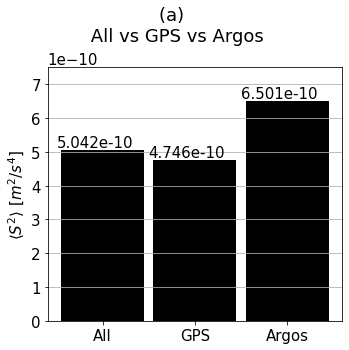

In [10]:
plot_S_bars([ds_all, ds_gps, ds_argos],['co_adt_oceantide_es_cstrio_z15_alti_x']*3, ticks = ['All', 'GPS','Argos'], fig_title='(a) \n All vs GPS vs Argos')

In [11]:
ds_saral_gps.compute()

<xarray.Dataset>
Dimensions:                                                         (id_comb: 72)
Coordinates:
    drifter_sat_year                                                <U20 'gps...
  * id_comb                                                         (id_comb) <U44 ...
Data variables: (12/1765)
    mean_alti_adt_g_grad_x                                          float64 1...
    mean_alti_adt_oceantide_dac_g_grad_x                            float64 2...
    mean_alti_adt_oceantide_g_grad_x                                float64 1...
    mean_alti_denoised_g_grad_x                                     float64 1...
    mean_alti_g_grad_x                                              float64 3...
    mean_aviso_alti_adt_g_grad_x                                    float64 -...
    ...                                                              ...
    var_sum_co_e5_cstrio_z15_alti_x                                 float64 1...
    var_sum_co_e5_cstrio_z15_drifter_x                              float64 1...
    var_sum_co_es_cstrio_z0_alti_x                                  float64 1...
    var_sum_co_es_cstrio_z0_drifter_x                               float64 1...
    var_sum_co_es_cstrio_z15_alti_x                                 float64 1...
    var_sum_co_es_cstrio_z15_drifter_x                              float64 1...

# all vs saral only vs sentinel only

acc:1.4866930198685818e-10, coriolis:4.269122649327955e-10, ggrad:3.2033641238796303e-10, wind:1.528972744600694e-11
acc:1.5032127970298802e-10, coriolis:4.2971180347513254e-10, ggrad:3.234902804333952e-10, wind:1.578272787022372e-11
acc:1.4700154239512371e-10, coriolis:4.240859805559519e-10, ggrad:3.1715243736434754e-10, wind:1.4792013511883158e-11


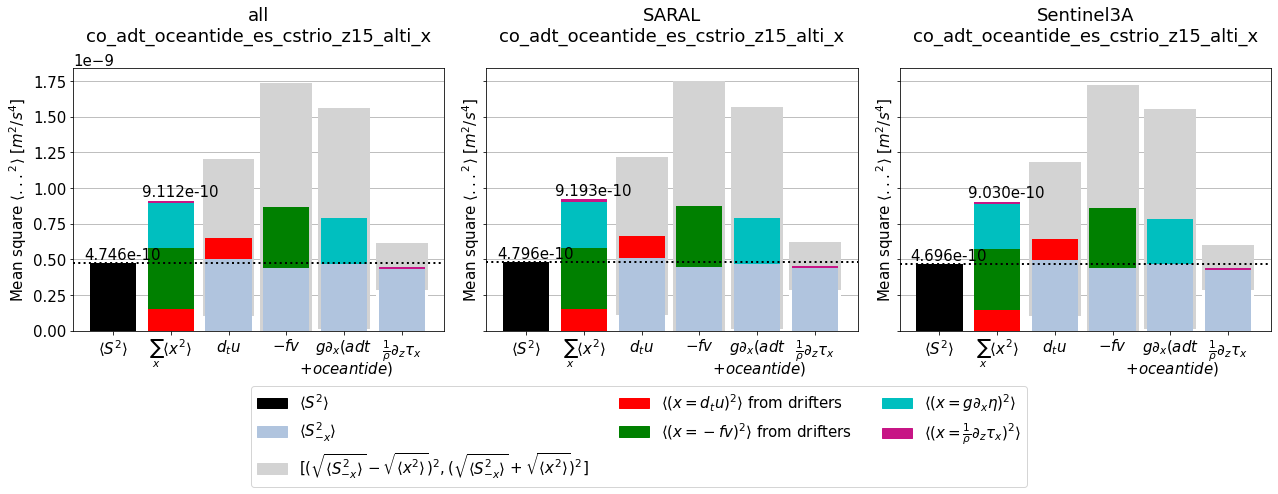

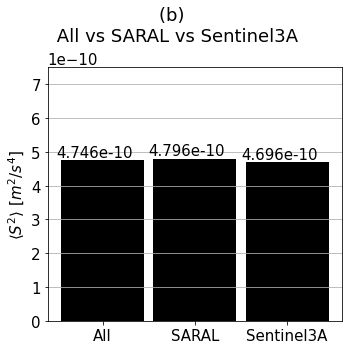

In [12]:
id_='co_adt_oceantide_es_cstrio_z15_alti_x'
#fig_title='All altimeters vs SARAL vs Sentinel3A'
fig_title=1
fig, axs = plt.subplots(nrows=1,ncols=3,
                            sharey='all',
                            figsize=(18,7))
plot_closure_bar(ds_gps, id_,axs[0], title = 'all')
plot_closure_bar(ds_saral_gps, id_,axs[1], title = 'SARAL')
plot_closure_bar(ds_sentinel_gps, id_,axs[2], title = 'Sentinel3A')
if isinstance(fig_title, str):
    fig.suptitle(fig_title,)


colors=['k', 'lightsteelblue','lightgrey', 'red', 'green', 'c','mediumvioletred']
labels_ = [r'$\langle S^2\rangle$',
           r'$\langle S_{-x}^2\rangle$',
           r'$[(\sqrt{\langle S_{-x}^2\rangle}-\sqrt{\langle x^2\rangle})^2,(\sqrt{\langle S_{-x}^2\rangle}+\sqrt{\langle x^2\rangle})^2$]',
           r'$\langle (x=d_tu)^2\rangle $ from drifters',
          r'$\langle (x=-fv)^2\rangle$ from drifters',
          r"$\langle (x=g\partial_x\eta)^2\rangle$",
           r"$\langle (x=\frac{1}{\rho}\partial_z\tau_x)^2\rangle$",
          ]                                                                                                                                                              

handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels_))]
fig.legend(handles, labels_, ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)

plot_S_bars([ds_gps, ds_saral_gps, ds_sentinel_gps],['co_adt_oceantide_es_cstrio_z15_alti_x']*3, ticks = ['All', 'SARAL','Sentinel3A'], fig_title='(b) \n All vs SARAL vs Sentinel3A')

In [13]:
## Combination of reference

acc:1.4866930198685818e-10, coriolis:4.269122649327955e-10, ggrad:3.2033641238796303e-10, wind:1.528972744600694e-11


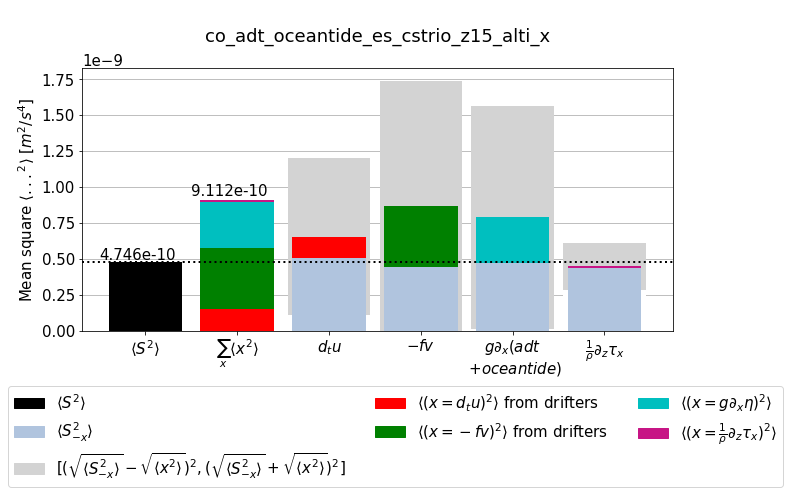

In [14]:
ID=['co_adt_oceantide_es_cstrio_z15_alti_x',]
titles = ['']
ticks = ["drifter's \n matchup"]
plot_comp_closure_bar(ds_gps, ID, titles = titles, figsize=(18,7), bottom = 0.2, loc='lower left')#,fig_title=fig_title)
#plot_S_bars([ds_gps],ID, ticks = ticks)#, fig_title=" at drifter's matchup vs\n at the altimeter's matchup")

acc:1.4866930198685818e-10, coriolis:4.269122649327955e-10, ggrad:3.2033641238796303e-10, wind:1.528972744600694e-11


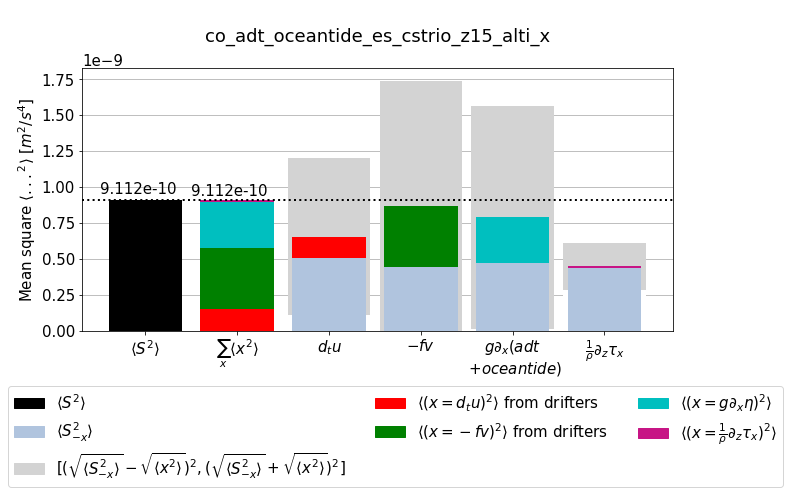

In [9]:
ID=['co_adt_oceantide_es_cstrio_z15_alti_x',]
titles = ['']
ticks = ["drifter's \n matchup"]
plot_comp_closure_bar(ds_gps, ID, titles = titles, figsize=(18,7), bottom = 0.2, loc='lower left')#,fig_title=fig_title)
#plot_S_bars([ds_gps],ID, ticks = ticks)#, fig_title=" at drifter's matchup vs\n at the altimeter's matchup")

# Wd at alti or drifter matchup

acc:1.4866930198685818e-10, coriolis:4.269122649327955e-10, ggrad:3.2033641238796303e-10, wind:1.537929805340011e-11
acc:1.4866930198685818e-10, coriolis:4.269122649327955e-10, ggrad:3.2033641238796303e-10, wind:1.528972744600694e-11


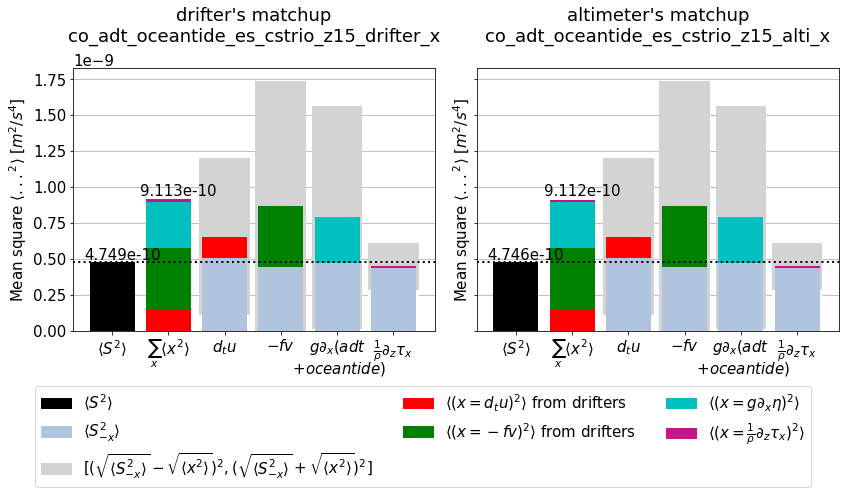

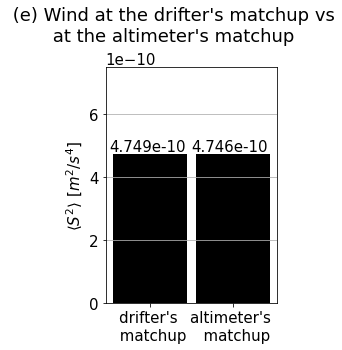

In [15]:
ID=['co_adt_oceantide_es_cstrio_z15_drifter_x','co_adt_oceantide_es_cstrio_z15_alti_x',]
fig_title = "Wind term interpolated at the drifter's matchup vs at the altimeter's matchup"
titles = ["drifter's matchup","altimeter's matchup",]
ticks = ["drifter's \n matchup","altimeter's \n  matchup",]
plot_comp_closure_bar(ds_gps, ID, titles = titles, bottom=0.2 )#,fig_title=fig_title)
plot_S_bars([ds_gps]*2,ID, ticks = ticks, fig_title=" (e) Wind at the drifter's matchup vs\n at the altimeter's matchup")

# z=0 vs z=15

acc:1.4866930198685818e-10, coriolis:4.269122649327955e-10, ggrad:3.2033641238796303e-10, wind:9.655620072588173e-11
acc:1.4866930198685818e-10, coriolis:4.269122649327955e-10, ggrad:3.2033641238796303e-10, wind:1.528972744600694e-11


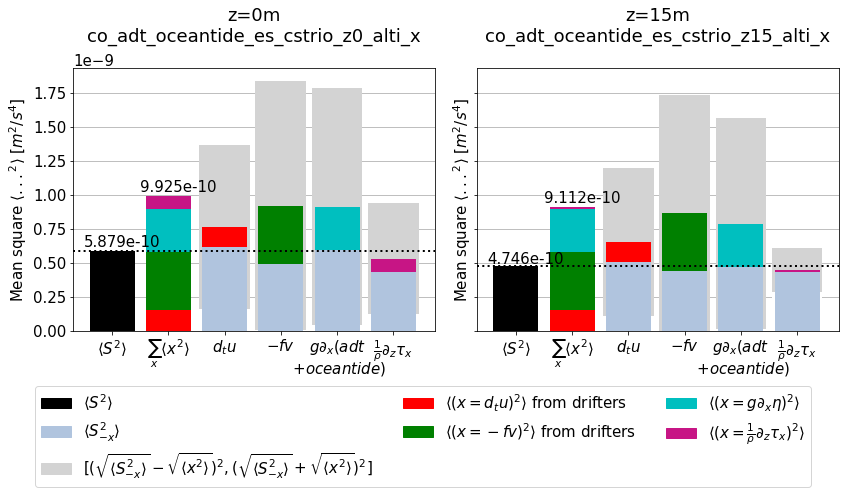

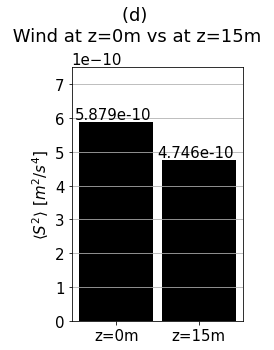

In [16]:
ID=['co_adt_oceantide_es_cstrio_z0_alti_x','co_adt_oceantide_es_cstrio_z15_alti_x',]
fig_title =  "Wind term computed at z=0m vs at z=15m "
titles = ["z=0m","z=15m",]
plot_comp_closure_bar(ds_gps, ID, titles=titles, bottom=0.2 )#,fig_title=fig_title)
plot_S_bars([ds_gps]*2,ID, ticks = titles, fig_title= "(d) \n Wind at z=0m vs at z=15m ")


# e5 vs es

acc:1.4866930198685818e-10, coriolis:4.269122649327955e-10, ggrad:3.2033641238796303e-10, wind:1.5573492773416933e-11
acc:1.4866930198685818e-10, coriolis:4.269122649327955e-10, ggrad:3.2033641238796303e-10, wind:1.528972744600694e-11


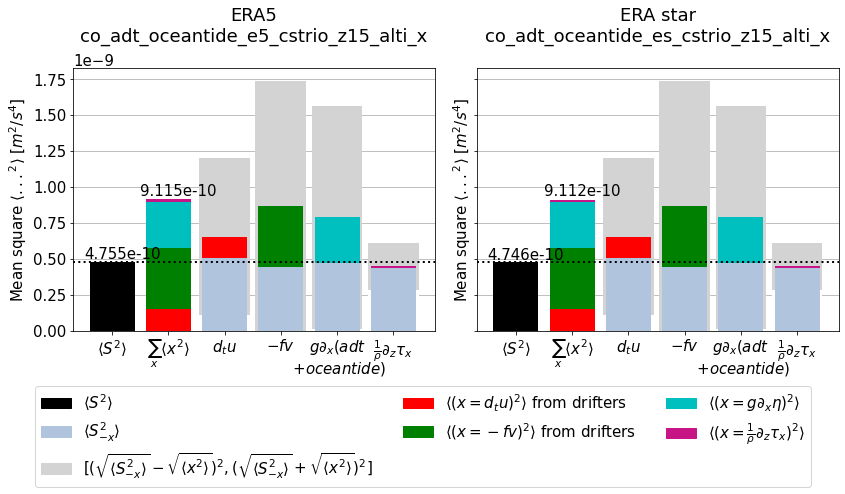

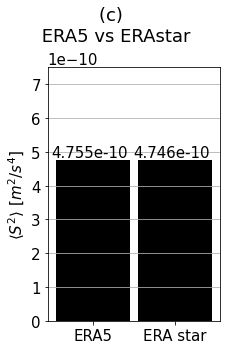

In [17]:
ID=['co_adt_oceantide_e5_cstrio_z15_alti_x','co_adt_oceantide_es_cstrio_z15_alti_x',]
titles = ["ERA5","ERA star",]
plot_comp_closure_bar(ds_gps, ID,titles=titles, bottom=0.2 )#,fig_title=fig_title)
plot_S_bars([ds_gps]*2,ID, ticks = titles, fig_title='(c) \n ERA5 vs ERAstar')

# Corrections 

acc:1.4866930198685818e-10, coriolis:4.269122649327955e-10, ggrad:2.705833289396599e-10, wind:1.528972744600694e-11
acc:1.4866930198685818e-10, coriolis:4.269122649327955e-10, ggrad:3.065458073675269e-10, wind:1.528972744600694e-11
acc:1.4866930198685818e-10, coriolis:4.269122649327955e-10, ggrad:3.2033641238796303e-10, wind:1.528972744600694e-11
acc:1.4866930198685818e-10, coriolis:4.269122649327955e-10, ggrad:3.177366774670969e-10, wind:1.528972744600694e-11


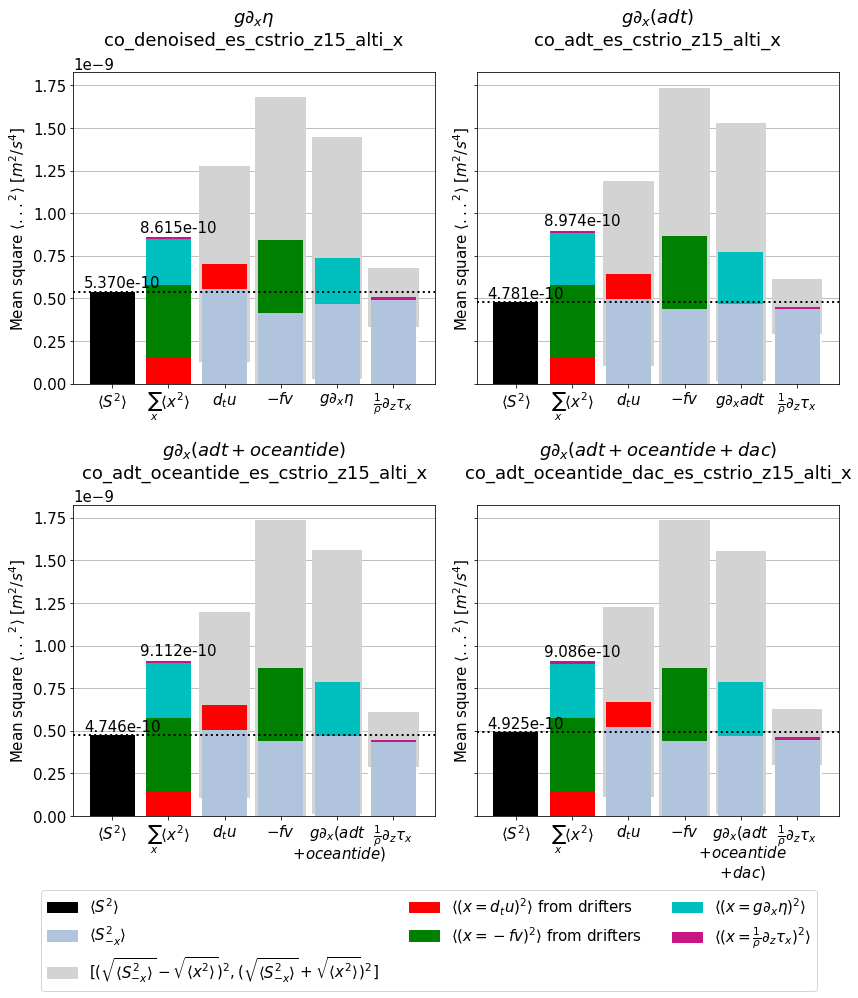

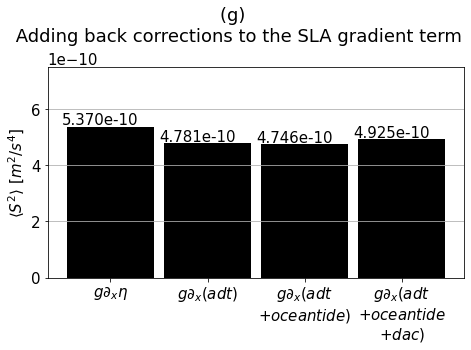

In [18]:
ID=['co_denoised_es_cstrio_z15_alti_x','co_adt_es_cstrio_z15_alti_x',
    'co_adt_oceantide_es_cstrio_z15_alti_x','co_adt_oceantide_dac_es_cstrio_z15_alti_x',]
fig_title = '(g) \n Adding back corrections to the SLA gradient term'
titles = [r"$g\partial_x\eta$",r"$g\partial_x(adt)$",r"$g\partial_x(adt+oceantide)$",r"$g\partial_x(adt+oceantide+dac)$",]
ticks = [r"$g\partial_x\eta$",r"$g\partial_x(adt)$",r"$g\partial_x(adt$"+"\n"+r"$+oceantide)$",r"$g\partial_x(adt$"+"\n"+r"$+oceantide$"+"\n"+"$+dac)$",]
plot_comp_closure_bar(ds_gps, ID, titles=titles, bottom=0.1 )#,fig_title=fig_title)
plot_S_bars([ds_gps]*4,ID, ticks = ticks, fig_title=fig_title)


# AVISO vs altimetry

acc:1.4866930198685818e-10, coriolis:4.269122649327955e-10, ggrad:1.6799063280021996e-10, wind:1.528972744600694e-11
acc:1.4866930198685818e-10, coriolis:4.269122649327955e-10, ggrad:1.6433194234295256e-10, wind:1.537929805340011e-11
acc:1.4866930198685818e-10, coriolis:4.269122649327955e-10, ggrad:3.065458073675269e-10, wind:1.528972744600694e-11


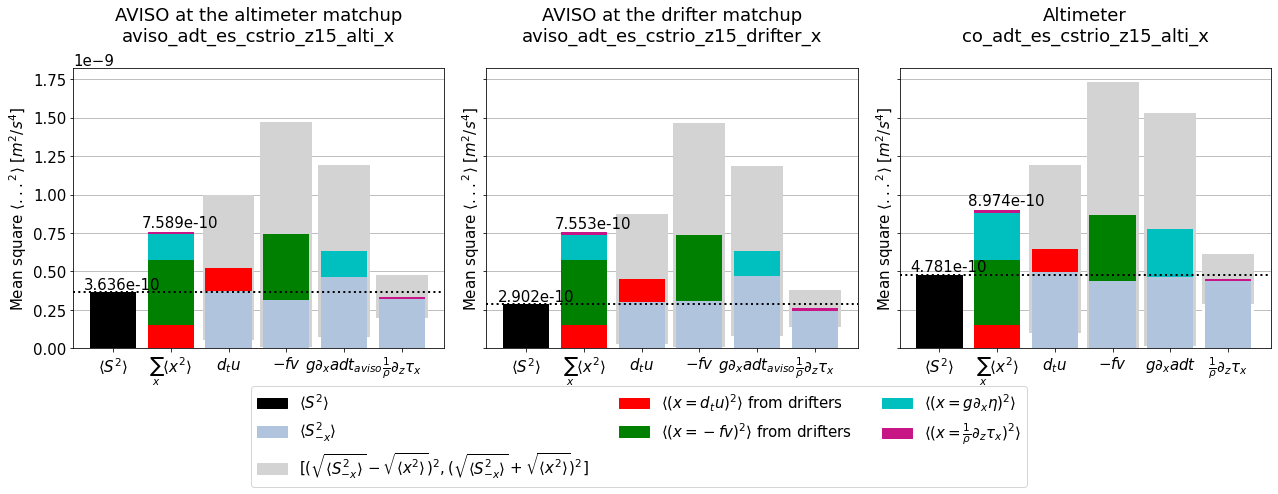

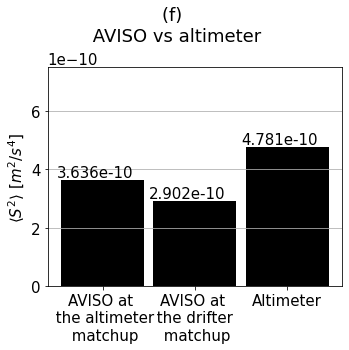

In [19]:
ID=['aviso_adt_es_cstrio_z15_alti_x',
    'aviso_adt_es_cstrio_z15_drifter_x',
    'co_adt_es_cstrio_z15_alti_x']
fig_title = "(f) \n AVISO vs altimeter"
titles = ['AVISO at the altimeter matchup', 'AVISO at the drifter matchup', 'Altimeter',]
ticks = ['AVISO at \n the altimeter\n matchup', 'AVISO at \n the drifter \n matchup', 'Altimeter',]
plot_comp_closure_bar(ds_gps, ID,  titles=titles, ncols=3, bottom =0.18 )
plot_S_bars([ds_gps]*3,ID, ticks = ticks, fig_title=fig_title)

In [20]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
